<a href="https://colab.research.google.com/github/Yugsolanki/ML-SC-Lab/blob/main/Fuzzy_Controller_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# 1. Fuzzy Set and Membership Function Implementation

In [3]:
class FuzzySet:
    def __init__(self, universe, mf):
        self.universe = universe
        self.mf = mf

    def membership(self, x):
        if np.isscalar(x):
            return self.mf(np.array([x]))[0]
        return self.mf(x)

def trimf(x, abc):
    a, b, c = abc
    if np.isscalar(x):
        return max(0, min((x-a)/(b-a), (c-x)/(c-b))) if a < x < c else 0
    else:
        x = np.asarray(x)
        y = np.zeros_like(x)
        idx = (a < x) & (x <= b)
        y[idx] = (x[idx] - a) / (b - a)
        idx = (b <= x) & (x < c)
        y[idx] = (c - x[idx]) / (c - b)
        y[x == b] = 1
        return y

# 2. Fuzzy Controller Implementation

In [4]:
class FuzzyController:
    def __init__(self):
        self.input_sets = {}
        self.output_sets = {}
        self.rules = []

    def add_input(self, name, sets):
        self.input_sets[name] = sets

    def add_output(self, name, sets):
        self.output_sets[name] = sets

    def add_rule(self, antecedents, consequent):
        self.rules.append((antecedents, consequent))

    def fuzzify(self, inputs):
        fuzzified = {}
        for name, value in inputs.items():
            fuzzified[name] = {
                set_name: fuzzy_set.membership(value)
                for set_name, fuzzy_set in self.input_sets[name].items()
            }
        return fuzzified

    def inference(self, fuzzified):
        output_mfs = {name: np.zeros_like(next(iter(sets.values())).universe)
                      for name, sets in self.output_sets.items()}

        for antecedents, consequent in self.rules:
            rule_strength = min(fuzzified[inp][set_name] for inp, set_name in antecedents)
            output_var, output_set = consequent
            output_mfs[output_var] = np.maximum(
                output_mfs[output_var],
                np.minimum(rule_strength, self.output_sets[output_var][output_set].mf(
                    self.output_sets[output_var][output_set].universe
                ))
            )

        return output_mfs

    def defuzzify(self, output_mfs):
        defuzzified = {}
        for name, mf in output_mfs.items():
            universe = next(iter(self.output_sets[name].values())).universe
            defuzzified[name] = np.sum(universe * mf) / np.sum(mf)
        return defuzzified

    def compute(self, inputs):
        fuzzified = self.fuzzify(inputs)
        output_mfs = self.inference(fuzzified)
        return self.defuzzify(output_mfs)

# 3. Setting up the Fuzzy Controller

In [5]:
# Define universes
temp_universe = np.linspace(0, 40, 100)
ac_universe = np.linspace(0, 100, 100)

# Define fuzzy sets
temp_cold = FuzzySet(temp_universe, lambda x: trimf(x, [0, 0, 20]))
temp_comfortable = FuzzySet(temp_universe, lambda x: trimf(x, [15, 22, 28]))
temp_hot = FuzzySet(temp_universe, lambda x: trimf(x, [25, 40, 40]))

ac_low = FuzzySet(ac_universe, lambda x: trimf(x, [0, 0, 50]))
ac_medium = FuzzySet(ac_universe, lambda x: trimf(x, [25, 50, 75]))
ac_high = FuzzySet(ac_universe, lambda x: trimf(x, [50, 100, 100]))

# Create and set up the controller
controller = FuzzyController()

controller.add_input('temperature', {
    'cold': temp_cold,
    'comfortable': temp_comfortable,
    'hot': temp_hot
})

controller.add_output('ac_power', {
    'low': ac_low,
    'medium': ac_medium,
    'high': ac_high
})

# Define rules
controller.add_rule([('temperature', 'cold')], ('ac_power', 'low'))
controller.add_rule([('temperature', 'comfortable')], ('ac_power', 'medium'))
controller.add_rule([('temperature', 'hot')], ('ac_power', 'high'))

# 4. Testing the Controller

In [6]:
test_temps = np.linspace(0, 40, 41)
ac_powers = [controller.compute({'temperature': t})['ac_power'] for t in test_temps]

# 5. Visualization

<ipython-input-4-993668a0ac88>:45: RuntimeWarning: invalid value encountered in scalar divide
  defuzzified[name] = np.sum(universe * mf) / np.sum(mf)


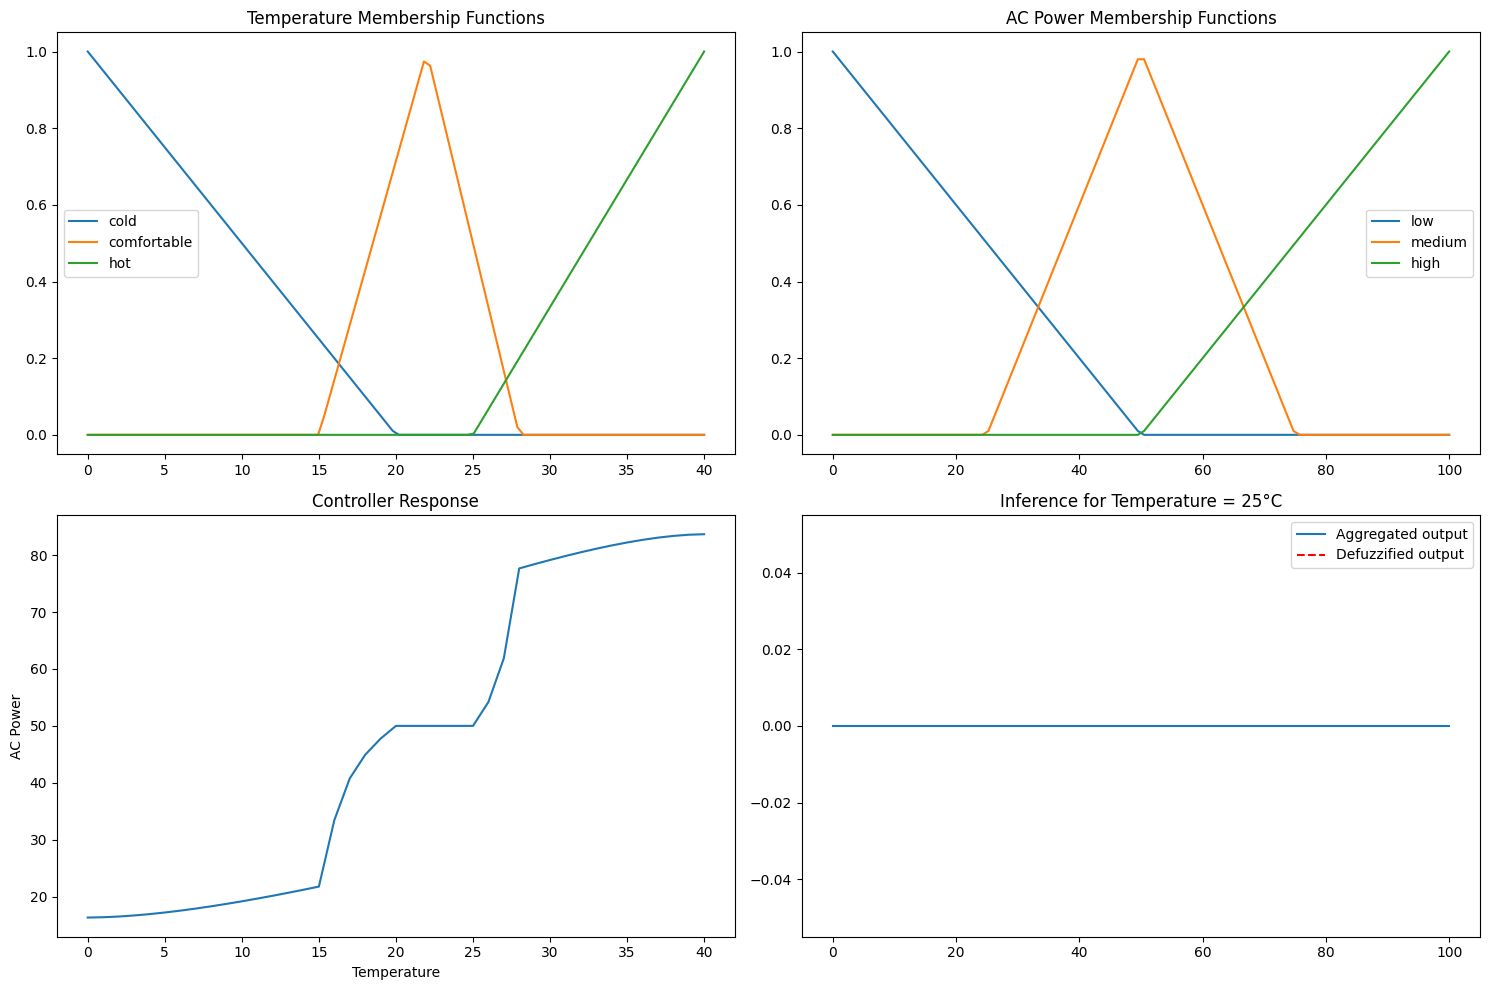

In [7]:
plt.figure(figsize=(15, 10))

# Input membership functions
plt.subplot(2, 2, 1)
for name, fuzzy_set in controller.input_sets['temperature'].items():
    plt.plot(fuzzy_set.universe, fuzzy_set.mf(fuzzy_set.universe), label=name)
plt.title('Temperature Membership Functions')
plt.legend()

# Output membership functions
plt.subplot(2, 2, 2)
for name, fuzzy_set in controller.output_sets['ac_power'].items():
    plt.plot(fuzzy_set.universe, fuzzy_set.mf(fuzzy_set.universe), label=name)
plt.title('AC Power Membership Functions')
plt.legend()

# Controller response
plt.subplot(2, 2, 3)
plt.plot(test_temps, ac_powers)
plt.title('Controller Response')
plt.xlabel('Temperature')
plt.ylabel('AC Power')

# Example of fuzzification, inference, and defuzzification
example_temp = 25
fuzzified = controller.fuzzify({'temperature': example_temp})
output_mfs = controller.inference(fuzzified)

plt.subplot(2, 2, 4)
for name, mf in output_mfs.items():
    plt.plot(ac_universe, mf, label='Aggregated output')
plt.axvline(controller.defuzzify(output_mfs)['ac_power'], color='r', linestyle='--', label='Defuzzified output')
plt.title(f'Inference for Temperature = {example_temp}°C')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Data Analysis

In [8]:
print("Controller Analysis:")
print(f"Temperature range: {min(test_temps):.1f}°C to {max(test_temps):.1f}°C")
print(f"AC power range: {min(ac_powers):.1f} to {max(ac_powers):.1f}")

# Find the temperature at which AC power changes most rapidly
power_derivative = np.diff(ac_powers) / np.diff(test_temps)
max_change_index = np.argmax(np.abs(power_derivative))
print(f"Maximum rate of change in AC power: at {test_temps[max_change_index]:.1f}°C")

# Compute and print the average AC power for each temperature range
cold_range = test_temps <= 15
comfortable_range = (test_temps > 15) & (test_temps < 25)
hot_range = test_temps >= 25

print(f"Average AC power in cold range: {np.mean(np.array(ac_powers)[cold_range]):.2f}")
print(f"Average AC power in comfortable range: {np.mean(np.array(ac_powers)[comfortable_range]):.2f}")
print(f"Average AC power in hot range: {np.mean(np.array(ac_powers)[hot_range]):.2f}")

Controller Analysis:
Temperature range: 0.0°C to 40.0°C
AC power range: 16.3 to 83.7
Maximum rate of change in AC power: at 27.0°C
Average AC power in cold range: 18.45
Average AC power in comfortable range: 46.32
Average AC power in hot range: 76.44
